In [1]:
import xarray as xr
import os
import pandas as pd
import cmweather
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,ScalarFormatter)


from glob import glob
# from dask_jobqueue import SLURMCluster
from distributed import Client, progress
from scipy.interpolate import interp1d

import sys
np.set_printoptions(suppress=True)

## J Cluster

In [2]:
nsa_data_path = '/lcrc/group/earthscience/NSA/Johannes-ck-new.dat'
nsa_cluster = pd.read_csv(nsa_data_path, index_col=["time"], parse_dates=True).to_xarray()

## E3SM Data

In [3]:
e3sm_columns = xr.open_dataset('/lcrc/group/earthscience/rjackson/e3sm_nsa/notebooks/subcols.nc')
e3sm_avgs = xr.open_dataset('/lcrc/group/earthscience/rjackson/e3sm_nsa/notebooks/E3SM_NSA_col_hourly_dump.nc')

In [4]:
dest_dir = '/lcrc/group/earthscience/rjackson/kazrcloudsat/hourly_ave/*.nc'
file_list = glob(dest_dir)
ds = xr.open_dataset(file_list[0])
heights = ds.height.values
ds.close()
refls = []
clusters = []
vels = []
seasons = []
for fi in file_list:
    ds = xr.open_dataset(fi)

    heights = ds.height.values
    refls.append(ds.reflectivity_best_estimate.values)
    vels.append(ds.mean_doppler_velocity.values)
    try:
        clusters.append(nsa_cluster["class"].sel(time=ds.time.values[0]).values * np.ones(ds.time.values.shape))
    except KeyError:
        clusters.append(np.nan*np.ones(ds.time.values.shape))
    try:
        seasons.append(ds.time.dt.season.values)
    except:
        seasons.append(np.nan*np.ones(ds.time.values.shape))
 

refls = np.concatenate(refls, axis=0)
vels = np.concatenate(vels, axis=0)
clusters = np.concatenate(clusters, axis=0)
seasons = np.concatenate(seasons, axis=0)

In [5]:
clusters

array([4., 4., 4., ..., 3., 3., 3.])

In [6]:
refl_bins = np.linspace(-50, 20, 40)
hists_ref = np.zeros((4, len(heights), len(refl_bins) - 1))
vel_bins = np.linspace(-2, 2, 40)
hists_vel = np.zeros((4, len(heights), len(vel_bins) - 1))
medians_ref = np.zeros((4, len(heights)))
medians_vel = np.zeros((4, len(heights)))  

for c in range(4):
    which_inds = np.argwhere(clusters == c+1)
    for h in range(len(heights)):
        hist, bins = np.histogram(refls[which_inds, h], bins=refl_bins)
        hists_ref[c, h] = hist / np.sum(hist)
        medians_ref[c, h] = np.nanpercentile(refls[which_inds, h], 50)
        hist, bins = np.histogram(vels[which_inds, h], bins=vel_bins)
        hists_vel[c, h] = hist / np.sum(hist)
        medians_vel[c, h] = np.nanpercentile(vels[which_inds, h], 50)
hists_ref = np.where(hists_ref > 0, hists_ref, np.nan)
hists_vel = np.where(hists_vel > 0, hists_vel, np.nan)

/tmp/ipykernel_301628/4269008533.py:12: RuntimeWarning: divide by zero encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/tmp/ipykernel_301628/4269008533.py:12: RuntimeWarning: invalid value encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/home/zhengx/.conda/envs/research/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tmp/ipykernel_301628/4269008533.py:15: RuntimeWarning: divide by zero encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)
/tmp/ipykernel_301628/4269008533.py:15: RuntimeWarning: invalid value encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)


In [7]:
Rd = 287.057
g0 = 9.80665
e3sm_avgs["P"] = e3sm_avgs["hyam"] * e3sm_avgs["P0"] + e3sm_avgs["hybm"] * e3sm_avgs["PS"]
e3sm_avgs["heights"] = Rd * e3sm_avgs["T"] * (-np.log(e3sm_avgs["P"]) + np.log(e3sm_avgs["PS"])) / g0 * 1e-3
rho = e3sm_avgs["P"] / (Rd * e3sm_avgs["T"])
content_conversion_factor = rho * 1e3
e3sm_avgs["CLOUD_FILTER"] = e3sm_avgs["CLOUD"].where(e3sm_avgs["CLOUD"] > 0.01)
LWC_array = e3sm_avgs["CLDLIQ"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
IWC_array = e3sm_avgs["CLDICE"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
LWC_array += e3sm_avgs["RAINQM"].values * content_conversion_factor
IWC_array += e3sm_avgs["SNOWQM"].values * content_conversion_factor
LWC_array = np.where(np.isfinite(LWC_array), LWC_array, 0)
IWC_array = np.where(np.isfinite(IWC_array), IWC_array, 0)
Ze = e3sm_columns["sub_col_Ze_tot"].mean(dim='subcolumn', skipna=True)

In [8]:
tolerance = np.timedelta64(1, 'D') / np.timedelta64(1, 'ns')
nsa_cluster = nsa_cluster.sortby('time').convert_calendar('noleap').reindex(time=e3sm_avgs.time, method='nearest')
e3sm_avgs["cluster"] = nsa_cluster["class"]
# e3sm_avgs["cluster"].plot()

In [9]:
clear_pct = 1 - e3sm_avgs["CLOUD"].values
height = np.sort(e3sm_avgs["heights"].values)
heights_prof = np.arange(0, 10000, 50.)
LWC_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
IWC_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
clear_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
Ze_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
for i in range(LWC_array.shape[0]):
    if i % 100 == 0:
        print('%d/%d' % (i, LWC_array.shape[0]))
    LWC = interp1d(height[i, :], LWC_array[i, :], fill_value="extrapolate")
    IWC = interp1d(height[i, :], IWC_array[i, :], fill_value="extrapolate")
    clear = interp1d(height[i, :], clear_pct[i, :], fill_value="extrapolate")
    Zei = interp1d(height[i, :], Ze[i, :], fill_value="extrapolate")
    Ze_array_interp[i, :] = Zei(heights_prof / 1e3)
    LWC_array_interp[i, :] = LWC(heights_prof / 1e3)
    IWC_array_interp[i, :] = IWC(heights_prof / 1e3)
    clear_array_interp[i, :] = clear(heights_prof / 1e3)

0/18000
100/18000
200/18000
300/18000
400/18000
500/18000
600/18000
700/18000
800/18000
900/18000
1000/18000
1100/18000
1200/18000
1300/18000
1400/18000
1500/18000
1600/18000
1700/18000
1800/18000
1900/18000
2000/18000
2100/18000
2200/18000
2300/18000
2400/18000
2500/18000
2600/18000
2700/18000
2800/18000
2900/18000
3000/18000
3100/18000
3200/18000
3300/18000
3400/18000
3500/18000
3600/18000
3700/18000
3800/18000
3900/18000
4000/18000
4100/18000
4200/18000
4300/18000
4400/18000
4500/18000
4600/18000
4700/18000
4800/18000
4900/18000
5000/18000
5100/18000
5200/18000
5300/18000
5400/18000
5500/18000
5600/18000
5700/18000
5800/18000
5900/18000
6000/18000
6100/18000
6200/18000
6300/18000
6400/18000
6500/18000
6600/18000
6700/18000
6800/18000
6900/18000
7000/18000
7100/18000
7200/18000
7300/18000
7400/18000
7500/18000
7600/18000
7700/18000
7800/18000
7900/18000
8000/18000
8100/18000
8200/18000
8300/18000
8400/18000
8500/18000
8600/18000
8700/18000
8800/18000
8900/18000
9000/18000
9100/18000


In [10]:
e3sm_avgs["Avg_Ze_height"] = xr.DataArray(
    data=Ze_array_interp,
    dims=["time", "height_prof"],
    coords={"time": e3sm_avgs.time.values, "height_prof": heights_prof * 1e-3})
e3sm_avgs["season"] = e3sm_avgs["time"].dt.season

In [ ]:
e3sm_avgs.load()

## Ploting EMC2 Vertical Profile

In [ ]:
lsize=20

fig, ax = plt.subplots(4, 2, figsize=(12, 20))
colors = ['b', 'g', 'k', 'r']
i = 0
def cluster_mean(x, cluster_no):
    return x.where(x["cluster"] == cluster_no).mean("time", skipna=True)

for cluster in [1, 2, 3, 4]:
    cmean = lambda x: cluster_mean(x, cluster)
    e3sm_groupby = e3sm_avgs.groupby("season").apply(cmean)
    e3sm_groupby = e3sm_groupby.set_coords(["season", "lev"])
    
    for i, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
        e3sm_groupby['Avg_Ze_height'].sel(season=season).T.plot(
            ax=ax[i, 0], y="height_prof", linewidth=3, label=str(cluster), color=colors[cluster - 1])

        ax[-1, 0].set_xlabel('$Z_{e}$ [dBZ]',fontsize=lsize)   
        ax[i, 0].set_ylabel('Altitude [km]',fontsize=lsize)
        ax[i, 0].set_title('')
        ax[i, 0].set_xlim([-40, -10])
        ax[i, 0].set_ylim([0, 4])
        ax[i, 0].tick_params(labelsize=lsize-2,length=8,width=2,direction='out',which='major')
        ax[i, 0].tick_params(length=4,width=2,direction='out',which='minor')
        ax[i, 0].yaxis.set_minor_locator(AutoMinorLocator(2)) 
        ax[i, 0].xaxis.set_minor_locator(AutoMinorLocator(5)) 
        ax[i, 0].xaxis.set_major_locator(MultipleLocator(5))
        for axis in ['top','bottom','left','right']:
            ax[i, 0].spines[axis].set_linewidth(2)   
            
            
        inds = np.logical_and(seasons == season, clusters == cluster)
        Ze_mean = np.nanmean(refls[inds, :], axis=0)
        ax[i, 1].plot(Ze_mean, heights / 1e3, color=colors[cluster - 1], linewidth=3)
        ax[i, 1].set_ylabel('Altitude [km]',fontsize=lsize)
        ax[-1, 1].set_xlabel('$Z_{e}$ [dBZ]',fontsize=lsize) 
        ax[i, 1].set_title('')
        ax[i, 1].set_xlim([-40, -10])
        ax[i, 1].set_ylim([0, 4])
        ax[i, 1].tick_params(labelsize=lsize-2,length=8,width=2,direction='out',which='major')
        ax[i, 1].tick_params(length=4,width=2,direction='out',which='minor')
        ax[i, 1].yaxis.set_minor_locator(AutoMinorLocator(2)) 
        ax[i, 1].xaxis.set_minor_locator(AutoMinorLocator(5)) 
        ax[i, 1].xaxis.set_major_locator(MultipleLocator(5))
        for axis in ['top','bottom','left','right']:
            ax[i, 1].spines[axis].set_linewidth(2)     

for i in range(4):
    for j in range(2):
        # Keep SON x labels and ticks
        if i != 3:
            ax[i, j].set_xticklabels([])
            ax[i, j].set_xlabel('')
        # Keep LWC y axis labels
        if j > 0:  # Remove y ticks for all but the first column
#             ax[i, j].set_yticks([])
            ax[i, j].set_yticklabels([])
            ax[i, j].set_ylabel('')

season_titles = ["DJF", "MAM", "JJA", "SON"]
# Apply additional specific settings based on the instructions
for i, season in enumerate(season_titles):
    for j in range(2):
        # Custom annotation for the season title
        if j == 0: xypos = 0.8
        if j == 1: xypos = 0.2
        ax[i, j].annotate(season, xy=(xypos, 0.925), xycoords='axes fraction', ha='center',
                          va='center', fontsize=20, color='black')
        
fig.subplots_adjust(left = 0.1, right = 0.97, bottom = 0.05, top = 0.98,hspace=0.1,wspace=0.1)
figname = '/home/zhengx/Research/NSA/IMG/EMC2_E3SM_KAZR_Jlabel_below4KM.png'
plt.savefig(figname,facecolor='white', edgecolor='none')

In [ ]:
e3sm_avgs

## Calculate the Micro vertical Dist

In [11]:
height = e3sm_avgs["heights"].values
ARRAIN_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
ARSNOW_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
AREI_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
AREL_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
ARRAIN_array = e3sm_avgs["ADRAIN"] / 2. * 1e6
ARSNOW_array = e3sm_avgs["ADSNOW"] / 2. * 1e6
AREI_array = e3sm_avgs["AREI"] 
AREL_array = e3sm_avgs["AREL"]
rho = e3sm_avgs["P"] / (Rd * e3sm_avgs["T"])
NUMICE_array_interp = np.zeros((LWC_array.shape[0], len(heights))) 
NUMLIQ_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMRAI_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMSNO_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMICE_array = e3sm_avgs["NUMICE"] * rho * 1e-6
NUMLIQ_array = e3sm_avgs["NUMLIQ"] * rho * 1e-6
NUMRAI_array = e3sm_avgs["NUMRAI"] * rho * 1e-6
NUMSNO_array = e3sm_avgs["NUMSNO"] * rho * 1e-6

In [12]:
for i in range(LWC_array.shape[0]):
#     if i % 100 == 0:
#         print('%d/%d' % (i, LWC_array.shape[0]))
    ARRAIN = interp1d(height[i, :], ARRAIN_array[i, :], fill_value="extrapolate")
    ARSNOW = interp1d(height[i, :], ARSNOW_array[i, :], fill_value="extrapolate")
    NUMRAI = interp1d(height[i, :], NUMRAI_array[i, :], fill_value="extrapolate")
    NUMSNO = interp1d(height[i, :], NUMSNO_array[i, :], fill_value="extrapolate")
    NUMICE = interp1d(height[i, :], NUMICE_array[i, :], fill_value="extrapolate")
    NUMLIQ = interp1d(height[i, :], NUMLIQ_array[i, :], fill_value="extrapolate")
    AREI = interp1d(height[i, :], AREI_array[i, :], fill_value="extrapolate")
    ARED = interp1d(height[i, :], AREL_array[i, :], fill_value="extrapolate")
    ARRAIN_array_interp[i, :] = ARRAIN(heights / 1e3)
    ARSNOW_array_interp[i, :] = ARSNOW(heights / 1e3)
    NUMICE_array_interp[i, :] = NUMICE(heights / 1e3)
    NUMLIQ_array_interp[i, :] = NUMLIQ(heights / 1e3)
    NUMRAI_array_interp[i, :] = NUMRAI(heights / 1e3)
    NUMSNO_array_interp[i, :] = NUMSNO(heights / 1e3)
    AREI_array_interp[i, :] = AREI(heights / 1e3)
    AREL_array_interp[i, :] = ARED(heights / 1e3)

In [18]:
rei_bins = np.arange(0, 500, 5)
num_bins = np.logspace(-6, -2, 100)

ARSNOW_array_interp = np.where(ARSNOW_array_interp > 0.00001, ARSNOW_array_interp, np.nan)
NUMSNO_array_interp = np.where(NUMSNO_array_interp > 0.00001, NUMSNO_array_interp, np.nan)

# Plotting by Clusters
for icc, clsts in enumerate([1, 2, 3, 4]):
    fig, ax = plt.subplots(4, 2, figsize=(7, 10))
    for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
        hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
        hist_N = np.zeros((len(heights), len(num_bins) - 1))
        dom_label = 0
        cur_max = 0

        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["cluster"].values == icc + 1))
        if num_in_label > cur_max:
            dom_label = clsts

        which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                    e3sm_avgs["cluster"].values == dom_label)

        for ih in range(len(heights)):
            hist, bins = np.histogram(ARSNOW_array_interp[which_inds, ih], bins=rei_bins)
            hist_rei[ih, :] = hist
            hist, bins = np.histogram(NUMSNO_array_interp[which_inds, ih], bins=num_bins)
            hist_N[ih, :] = hist
        hist_rei[hist_rei == 0] = np.nan
        hist_N[hist_N == 0] = np.nan
        x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
        c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
        plt.colorbar(c, ax=ax[k, 0], label="count")
        ax[-1, 0].set_xlabel('Snow $r_{e}$ [$\mu m$]')
        ax[k, 0].set_ylabel('Altitude [km]')
        ax[k, 0].set_ylim([0, 10])
        ax[k, 0].set_title(seas)
        x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
        c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
        plt.colorbar(c, ax=ax[k, 1], label="count")
        ax[-1, 1].set_xlabel('Snow $N$ [$cm^{-3}$]')
        ax[k, 1].set_ylabel('Altitude [km]')
        ax[k, 1].set_ylim([0, 10])
        ax[k, 1].set_title(seas)
    fig.tight_layout()

    figname = '/home/zhengx/Research/NSA/IMG/Micro/E3SM_Jlabel_Snow_micro_Vert_Dist_C'+str(clsts)+'.png'
    plt.savefig(figname,facecolor='white', edgecolor='none')
    plt.close()

In [20]:
#
rei_bins = np.arange(0, 20, 1)
num_bins = np.arange(0,102,2)#np.logspace(0, 3, 100)

AREL_array_interp = np.where(AREL_array_interp > 1, AREL_array_interp, np.nan)
NUMLIQ_array_interp = np.where(NUMLIQ_array_interp > 1, NUMLIQ_array_interp, np.nan)

# Plotting by Clusters
for icc, clsts in enumerate([1, 2, 3, 4]):
    fig, ax = plt.subplots(4, 2, figsize=(7, 10))
    for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
        hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
        hist_N = np.zeros((len(heights), len(num_bins) - 1))
        dom_label = 0
        cur_max = 0

        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["cluster"].values == icc + 1))
        if num_in_label > cur_max:
            dom_label = clsts

        which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                    e3sm_avgs["cluster"].values == dom_label)

        for ih in range(len(heights)):
            hist, bins = np.histogram(AREL_array_interp[which_inds, ih], bins=rei_bins)
            hist_rei[ih, :] = hist
            hist, bins = np.histogram(NUMLIQ_array_interp[which_inds, ih], bins=num_bins)
            hist_N[ih, :] = hist
        hist_rei[hist_rei == 0] = np.nan
        hist_N[hist_N == 0] = np.nan
        x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
        c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Bu10_r')
        plt.colorbar(c, ax=ax[k, 0], label="count")
        ax[-1, 0].set_xlabel('Liquid $r_{e}$ [$\mu m$]')
        ax[k, 0].set_ylabel('Altitude [km]')
        ax[k, 0].set_ylim([0, 10])
        ax[k, 0].set_title(seas)
        x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
        c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Bu10_r')
        plt.colorbar(c, ax=ax[k, 1], label="count")
        ax[-1, 1].set_xlabel('Liquid $N$ [$cm^{-3}$]')
        ax[k, 1].set_ylabel('Altitude [km]')
        ax[k, 1].set_ylim([0, 10])
        ax[k, 1].set_title(seas)
    fig.tight_layout()

    figname = '/home/zhengx/Research/NSA/IMG/Micro/E3SM_Jlabel_Liq_micro_Vert_Dist_C'+str(clsts)+'.png'
    plt.savefig(figname,facecolor='white', edgecolor='none')
    plt.close()

In [21]:
rei_bins = np.arange(0, 150, 3)
num_bins = np.logspace(-4, 0.3, 50)

AREI_array_interp = np.where(AREI_array_interp > 0.001, AREI_array_interp, np.nan)
NUMICE_array_interp = np.where(NUMICE_array_interp > 0.001, NUMICE_array_interp, np.nan)

# Plotting by Clusters
for icc, clsts in enumerate([1, 2, 3, 4]):
    fig, ax = plt.subplots(4, 2, figsize=(7, 10))
    for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
        hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
        hist_N = np.zeros((len(heights), len(num_bins) - 1))
        dom_label = 0
        cur_max = 0

        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["cluster"].values == icc + 1))
        if num_in_label > cur_max:
            dom_label = clsts

        which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                    e3sm_avgs["cluster"].values == dom_label)

        for ih in range(len(heights)):
            hist, bins = np.histogram(AREI_array_interp[which_inds, ih], bins=rei_bins)
            hist_rei[ih, :] = hist
            hist, bins = np.histogram(NUMICE_array_interp[which_inds, ih], bins=num_bins)
            hist_N[ih, :] = hist
        hist_rei[hist_rei == 0] = np.nan
        hist_N[hist_N == 0] = np.nan
        x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
        c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
        plt.colorbar(c, ax=ax[k, 0], label="count")
        ax[-1, 0].set_xlabel('Ice $r_{e}$ [$\mu m$]')
        ax[k, 0].set_ylabel('Altitude [km]')
        ax[k, 0].set_ylim([0, 10])
        ax[k, 0].set_title(seas)
        x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
        c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
        plt.colorbar(c, ax=ax[k, 1], label="count")
        ax[-1, 1].set_xlabel('Ice $N$ [$cm^{-3}$]')
        ax[k, 1].set_ylabel('Altitude [km]')
        ax[k, 1].set_ylim([0, 10])
        ax[k, 1].set_title(seas)
    fig.tight_layout()

    figname = '/home/zhengx/Research/NSA/IMG/Micro/E3SM_Jlabel_Ice_micro_Vert_Dist_C'+str(clsts)+'.png'
    plt.savefig(figname,facecolor='white', edgecolor='none')
    plt.close()

In [ ]:
NUMSNO_array_interp.max()

## Microphysics Seasonal Variation

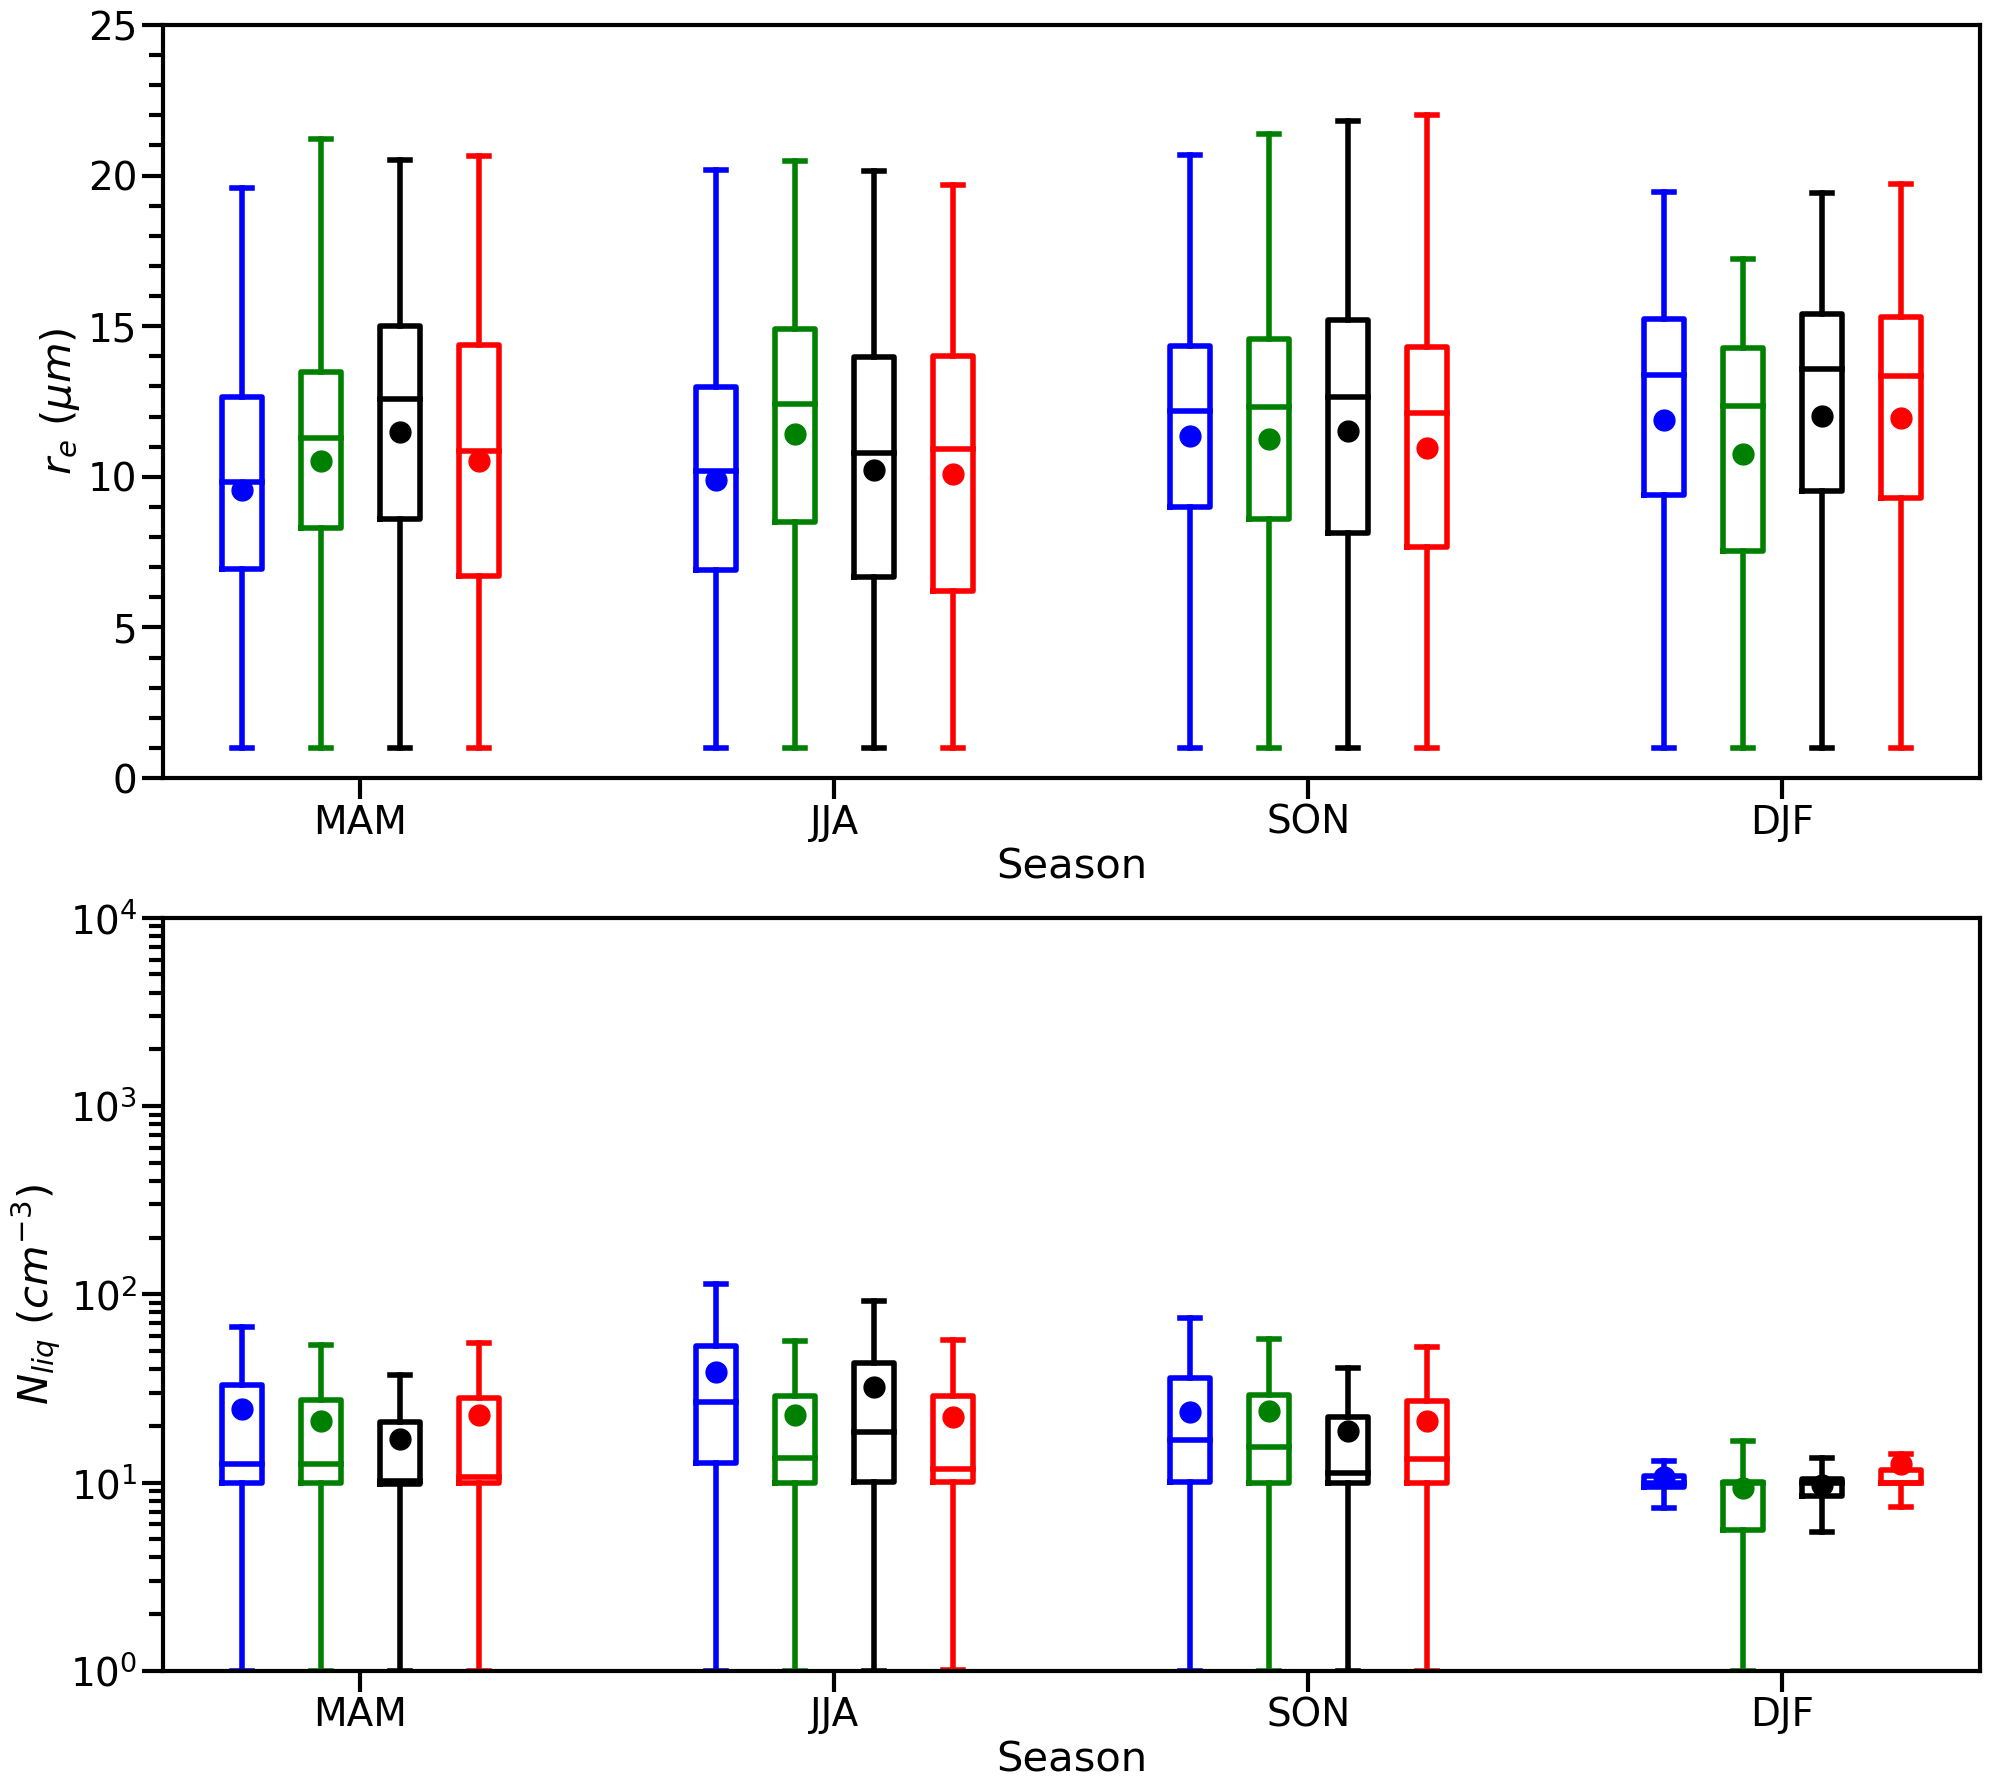

In [22]:
#--------------------------------------------------------------
# Group and cluster labels
xseas = ['MAM', 'JJA', 'SON', 'DJF']
colors = ['blue', 'green', 'black', 'red']
lsize = 30
#--------------------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(20, 18))
# set minimum threshold for plotting
AREL_array_interp = np.where(AREL_array_interp > 1, AREL_array_interp, np.nan)
NUMLIQ_array_interp = np.where(NUMLIQ_array_interp > 1, NUMLIQ_array_interp, np.nan)

positions = []  # To store the positions for the boxes

for k, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["cluster"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
        which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                    e3sm_avgs["cluster"].values == dom_label)

        tmpRe = AREL_array_interp[which_inds, :].copy()
        tmpNd = NUMLIQ_array_interp[which_inds, :].copy()

        # get the below 2km proportion
        lowloc = np.where(heights < 2000)[0]

        tmpRe_low0 = tmpRe[:,lowloc].copy()
        tmpNd_low0 = tmpNd[:,lowloc].copy() 

        tmpRe_low = tmpRe_low0[tmpRe_low0 > 1]
        tmpNd_low = tmpNd_low0[tmpNd_low0 > 1]
        #--------------------------------------------------------------
        # plotting boxes for all cluster 
        #define plotting properties.
        icolor=colors[i]
        boxpps = dict(linestyle='-', linewidth=4, color=icolor)
        meanpps = dict(marker='o', markeredgecolor=icolor,
                              markerfacecolor=icolor,ms=15)
        medianpps = dict(linestyle='-', linewidth=4, color=icolor)
        whiskerpps = dict(linestyle='-', linewidth=4, color=icolor)
        cappps = dict(linestyle='-', linewidth=4, color=icolor)
        
        pos = k * 6 + i + 1  # Calculate position
        positions.append(pos)
        #--------------------------------------------------------------
        #----------------------------------------------------------------------------------------------
        # Re
        ax[0].boxplot(tmpRe_low, positions=[pos], widths=0.5,boxprops=boxpps,medianprops=medianpps,
            showmeans=True,meanprops=meanpps,whiskerprops=whiskerpps,capprops=cappps,showfliers=False)
        ax[0].set_xticks([k * 6 + 2.5 for k in range(4)], xseas)
        ax[0].set_xlabel('Season',fontsize=lsize)
        ax[0].set_ylabel('$r_{e}$ ($\mu m$)',fontsize=lsize)
        ax[0].set_xlim([0, 23])
        ax[0].set_ylim([0, 25])
        ax[0].yaxis.set_minor_locator(AutoMinorLocator(5)) 
        ax[0].tick_params(labelsize=lsize-2,length=15,width=3,direction='out',which='major')
        ax[0].tick_params(length=10,width=3,direction='out',which='minor')
        for axis in ['top','bottom','left','right']:
            ax[0].spines[axis].set_linewidth(3) 
        #----------------------------------------------------------------------------------------------
        # Nd
        ax[1].boxplot(tmpNd_low, positions=[pos], widths=0.5,boxprops=boxpps,medianprops=medianpps,
            showmeans=True,meanprops=meanpps,whiskerprops=whiskerpps,capprops=cappps,showfliers=False)  
        ax[1].set_xticks([k * 6 + 2.5 for k in range(4)], xseas)
        ax[1].set_xlabel('Season',fontsize=lsize)
        ax[1].set_ylabel('$N_{liq}$ ($cm^{-3}$)',fontsize=lsize)
        ax[1].set_xlim([0, 23])
        ax[1].set_ylim([1, 10000])
        ax[1].set_yscale('log')
#         ax[1].yaxis.set_minor_locator(AutoMinorLocator(4)) 
        ax[1].tick_params(labelsize=lsize-2,length=15,width=3,direction='out',which='major')
        ax[1].tick_params(length=10,width=3,direction='out',which='minor')
        for axis in ['top','bottom','left','right']:
            ax[1].spines[axis].set_linewidth(3) 
        #----------------------------------------------------------------------------------------------
fig.tight_layout()
figname = '/home/zhengx/Research/NSA/IMG/E3SM_Jlabel_MICRO_Seasonal_below2km.png'
plt.savefig(figname,facecolor='white', edgecolor='none')